In [1]:
!pip install xgboost

# Importing necessary libraries
import numpy as np
import pandas as pd

#  Loading the CSV files
df_drivers = pd.read_csv("/content/drive/MyDrive/F1 race data to 2025/drivers (2).csv")
df_races = pd.read_csv("/content/drive/MyDrive/F1 race data to 2025/races (5).csv")
df_results = pd.read_csv("/content/drive/MyDrive/F1 race data to 2025/results.csv")
df_qualifying = pd.read_csv("/content/drive/MyDrive/F1 race data to 2025/qualifying.csv")

#  Quick check: previewing datasets
print("Drivers dataset shape:", df_drivers.shape)
print("Races dataset shape:", df_races.shape)
print("Results dataset shape:", df_results.shape)
print("Qualifying dataset shape:", df_qualifying.shape)

df_drivers.dropna(inplace=True)
df_races.dropna(inplace=True)
df_results.dropna(inplace=True)
df_qualifying.dropna(inplace=True)


Drivers dataset shape: (616, 5)
Races dataset shape: (1149, 7)
Results dataset shape: (7600, 9)
Qualifying dataset shape: (3017, 7)


In [2]:
races_data = df_races[['race_id', 'season', 'round', 'race_name', 'circuit_id']]
drivers_data = df_drivers[['driver_id', 'givenName', 'familyName', 'nationality']]
qualifying_data = df_qualifying[['race_id', 'driver_id', 'position']]
results_data = df_results[['race_id', 'driver_id', 'constructor_id', 'grid', 'position_order']]

qualifying_data.rename(columns={'position': 'qualifying_position'}, inplace=True)
results_data.rename(columns={'position_order': 'race_position'}, inplace=True)


/tmp/ipython-input-1633339042.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qualifying_data.rename(columns={'position': 'qualifying_position'}, inplace=True)
/tmp/ipython-input-1633339042.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_data.rename(columns={'position_order': 'race_position'}, inplace=True)


In [3]:
df = results_data.merge(races_data, on='race_id', how='left')
df = df.merge(drivers_data, on='driver_id', how='left')
df = df.merge(qualifying_data, on=['race_id', 'driver_id'], how='left')

df['qualifying_position'].fillna(30, inplace=True)


/tmp/ipython-input-698716852.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['qualifying_position'].fillna(30, inplace=True)


In [4]:
df['winner'] = (df['race_position'] == 1).astype(int)


In [5]:
df = df.sort_values('race_id')

df['avg_finish_last5'] = (
    df.groupby('driver_id')['race_position']
    .rolling(5)
    .mean()
    .reset_index(level=0, drop=True)
)

df['avg_finish_last5'].fillna(df['race_position'].mean(), inplace=True)


/tmp/ipython-input-316873918.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_finish_last5'].fillna(df['race_position'].mean(), inplace=True)


In [6]:
df['constructor_avg_finish'] = (
    df.groupby('constructor_id')['race_position']
    .transform('mean')
)


In [7]:
df['qual_vs_grid'] = df['grid'] - df['qualifying_position']


In [8]:
X = df.drop(columns=[
    'winner',
    'race_position',
    'givenName',
    'familyName'
])

y = df['winner']


In [9]:
categorical_cols = X.select_dtypes(include='object').columns
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

data = pd.concat([X, y], axis=1).dropna()
X = data.drop('winner', axis=1)
y = data['winner']


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = XGBClassifier(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=-1, num_parallel_tree=None, ...)

In [12]:
y_prob = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))


ROC-AUC: 0.9475788031064413
PR-AUC: 0.366841905040731


In [16]:
df_test = df.loc[X_test.index].copy()
df_test['pred_prob'] = y_prob

top3 = (
    df_test
    .sort_values(['race_id', 'pred_prob'], ascending=[True, False])
    .groupby('race_id')
    .head(3)
)

print("🏆 Winner in Top 3 Predictions:", top3['winner'].mean())


🏆 Winner in Top 3 Predictions: 0.08


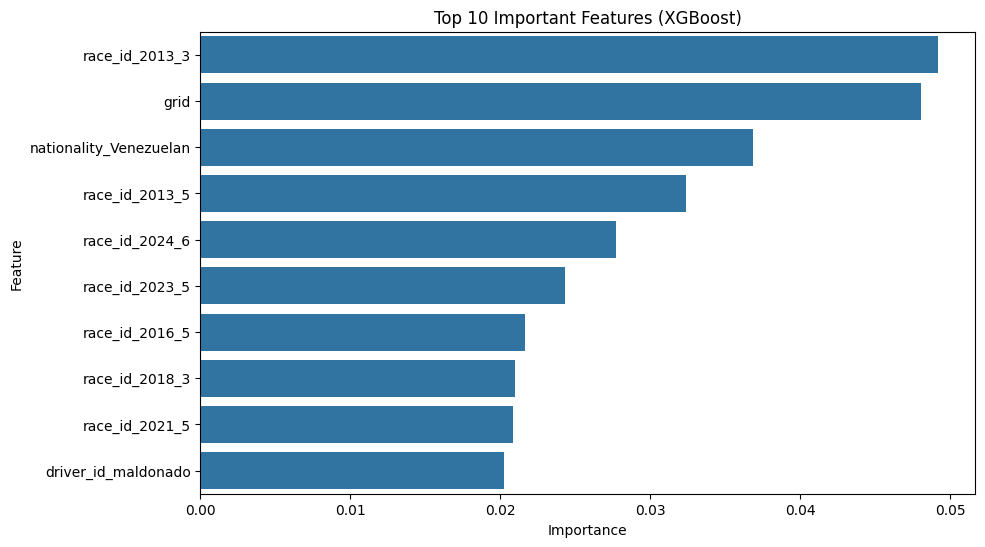

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Top 10 Important Features (XGBoost)")
plt.show()

In [21]:
driver_name_input = input("Enter the driver's last name: ")
year_input = int(input("Enter the target year: "))
race_round_input = int(input("Enter the race round: "))
grid_pos_input = int(input("Enter the grid position: "))
qual_pos_input = int(input("Enter the qualifying position: "))


Enter the driver's last name: hamilton
Enter the target year: 2026
Enter the race round: 12
Enter the grid position: 2
Enter the qualifying position: 2


In [22]:
def predict_driver_win_xgb(
    driver_last_name,
    season,
    race_round,
    grid_pos,
    qual_pos,
    model,
    X_columns,
    df_drivers,
    df_full
):
    driver = df_drivers[df_drivers['familyName'].str.lower() == driver_last_name.lower()]
    if driver.empty:
        print("❌ Driver not found")
        return

    driver_id = driver['driver_id'].iloc[0]
    nationality = driver['nationality'].iloc[0]

    constructor_id = (
        df_full[df_full['driver_id'] == driver_id]
        .sort_values('race_id')
        .iloc[-1]['constructor_id']
    )

    avg_finish = (
        df_full[df_full['driver_id'] == driver_id]
        .sort_values('race_id')
        .tail(5)['race_position']
        .mean()
    )

    constructor_avg = (
        df_full[df_full['constructor_id'] == constructor_id]['race_position']
        .mean()
    )

    X_pred = pd.DataFrame(0, index=[0], columns=X_columns)

    X_pred['driver_id'] = driver_id
    X_pred['season'] = season
    X_pred['round'] = race_round
    X_pred['grid'] = grid_pos
    X_pred['qualifying_position'] = qual_pos
    X_pred['qual_vs_grid'] = grid_pos - qual_pos
    X_pred['avg_finish_last5'] = avg_finish
    X_pred['constructor_avg_finish'] = constructor_avg

    nat_col = f'nationality_{nationality}'
    if nat_col in X_pred.columns:
        X_pred[nat_col] = 1

    con_col = f'constructor_id_{constructor_id}'
    if con_col in X_pred.columns:
        X_pred[con_col] = 1

    X_pred = X_pred[X_columns]

    prob = model.predict_proba(X_pred)[:, 1][0]

    print("\n🏁 WIN PROBABILITY PREDICTION")
    print(f"Driver: {driver_last_name}")
    print(f"Season: {season}, Round: {race_round}")
    print(f"Grid: {grid_pos}, Qualifying: {qual_pos}")
    print(f"Predicted Win Probability: {prob:.2%}")
predict_driver_win_xgb(
    driver_last_name=driver_name_input,
    season=year_input,
    race_round=race_round_input,
    grid_pos=grid_pos_input,
    qual_pos=qual_pos_input,
    model=model,
    X_columns=X.columns,
    df_drivers=df_drivers,
    df_full=df
)



🏁 WIN PROBABILITY PREDICTION
Driver: hamilton
Season: 2026, Round: 12
Grid: 2, Qualifying: 2
Predicted Win Probability: 12.36%


GRAPHICS


In [ ]:
!pip install gradio


In [23]:
import gradio as gr
import pandas as pd
import numpy as np

# ------------------ PREDICTION FUNCTION ------------------
def predict_f1_winner(driver_last_name, year, grid_pos, qual_pos, race_round):
    driver_info = df_drivers[df_drivers['familyName'].str.lower() == driver_last_name.lower()]
    if driver_info.empty:
        return "<h3 style='color:#ffcccc;text-align:center;'>❌ Driver not found</h3>"

    driver_id = driver_info['driver_id'].iloc[0]
    given_name = driver_info['givenName'].iloc[0]
    nationality = driver_info['nationality'].iloc[0]

    # Get constructor (most recent)
    constructor_id = df_features[df_features['driver_id'] == driver_id]['constructor_id'].mode().iloc[0]

    # Build prediction row
    X_pred = pd.DataFrame(0, index=[0], columns=X.columns)
    X_pred['grid'] = grid_pos
    X_pred['season'] = year
    X_pred['round'] = race_round
    X_pred['qualifying_position'] = qual_pos

    # Engineered features
    avg_finish = df_features[df_features['driver_id'] == driver_id].sort_values('race_id').tail(5)['race_position'].mean()
    constructor_avg = df_features[df_features['constructor_id'] == constructor_id]['race_position'].mean()
    X_pred['avg_finish_last5'] = avg_finish
    X_pred['constructor_avg_finish'] = constructor_avg
    X_pred['qual_vs_grid'] = grid_pos - qual_pos

    # One-hot categorical
    nat_col = f"nationality_{nationality}"
    cons_col = f"constructor_id_{constructor_id}"
    if nat_col in X_pred.columns:
        X_pred[nat_col] = 1
    if cons_col in X_pred.columns:
        X_pred[cons_col] = 1

    # Align columns with training data
    X_pred = X_pred[X.columns]

    # Predict probability using XGBoost model
    prob = model.predict_proba(X_pred)[0][1]

    return f"""
<div style="
background:linear-gradient(135deg,#590000,#8b0000);
padding:28px;
border-radius:18px;
text-align:center;
color:white;
box-shadow:0 12px 40px rgba(0,0,0,0.7);
">
<h2>🏁 Prediction Result</h2>
<h3>{given_name} {driver_last_name.title()}</h3>
<p>Season {year} • Round {race_round}</p>
<p>Grid: {grid_pos} | Qualifying: {qual_pos}</p>
<h1 style="color:#ffd6d6;margin-top:15px;">
🏆 {prob*100:.2f}% Chance to Win
</h1>
</div>
"""
# ------------------ PURE F1 CSS ------------------
custom_css = """
:root {
    --primary-red: #e10600;
    --dark-red: #590000;
    --maroon: #8b0000;
    --black-red: #120000;
}

body, .gradio-container {
    background: linear-gradient(120deg, #120000, #3b0000, #120000) !important;
}

h1, h2, h3, label, p {
    color: #ffffff !important;
}

button {
    background: linear-gradient(135deg, #e10600, #8b0000) !important;
    border: none !important;
    color: white !important;
    font-weight: bold;
}

input, textarea, select {
    background: #1a0000 !important;
    color: white !important;
    border: 1px solid #8b0000 !important;
}

footer {display:none !important;}
"""

# ------------------ GRADIO APP ------------------
with gr.Blocks(css=custom_css) as demo:

    gr.Markdown("""
    <h1 style="text-align:center;letter-spacing:2px;">
        🏎️ FORMULA 1 RACE WINNER PREDICTION
    </h1>
    """)

    gr.HTML("""
    <div style="
        display:flex;
        flex-direction:column;
        align-items:center;
        justify-content:center;
        margin-top:10px;
        margin-bottom:30px;
    ">
        <img src="https://upload.wikimedia.org/wikipedia/commons/3/33/F1.svg"
             style="width:140px; margin-bottom:12px;">
        <div style="text-align:center;">
            <b>XGBoost ML Model</b><br>
            <span style="color:#ffb3b3;">
                Red • Power • Speed • Precision
            </span>
        </div>
    </div>
    """)

    with gr.Row():
        driver = gr.Textbox(label="Driver Last Name", placeholder="Verstappen")
        year = gr.Number(label="Season Year", value=2025)

    with gr.Row():
        grid = gr.Slider(1, 20, value=1, label="Grid Position")
        qual = gr.Slider(1, 20, value=1, label="Qualifying Position")
        rnd = gr.Slider(1, 25, value=1, label="Race Round")

    btn = gr.Button("🏁 PREDICT WINNER")
    output = gr.Markdown()

    btn.click(
        predict_f1_winner,
        inputs=[driver, year, grid, qual, rnd],
        outputs=output
    )

demo.launch(share=True)


/tmp/ipython-input-475704580.py:98: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css) as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://de0d8016573326b748.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
